In [12]:
import pandas as pd

from collections import defaultdict
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from sklearn.decomposition import TruncatedSVD


from sklearn.cluster import KMeans

import seaborn as sns


DIR = "/home/bryce/Projects/Data_Science/Apt_Prices/csvs/march8/"

In [64]:
blurb_csv = DIR + "addr_scraping_results.csv"
df = pd.read_csv(blurb_csv, sep=';', header=None, names=['address', 'url', 'title', 'bullets', 'blurb'])

In [5]:
WORDS_TO_DROP = set(['a', 'on', 'our', 'all', 'at', 'and', '$250', 'with', 'the', 'is', 'or', 'this', 'that', 'of', 'to', 'in', 'for', 'you', 'as', '-'])


In [97]:
def blurb_to_dict(blurb):
    punc_removed = re.sub('[\.\,\:]', '', blurb)
    words = punc_removed.split()
    words = map(lambda w : w.lower(), words)
    word_count = defaultdict(int)
    for w in words:
        if w in WORDS_TO_DROP:
            continue
        word_count[w] += 1
    return word_count

def display_dict(d):
    return sorted(d.items(), key=lambda p : p[1], reverse=True)

Below is code to generate a dictionary of the word count for the entire corpus (all apartments combined)

In [98]:


def add_counts(word_count1, word_count2):
    for w, c in word_count2.items():
        word_count1[w] += c 
    return word_count1

# This function gives us the total word count for all the listings. We'll take a look at the count frequency to get an idea of what vocabulary to use.
def get_combined_word_count(df):
    word_counts = defaultdict(int)

    for blurb in df.blurb.items():
        wc = blurb_to_dict(blurb[1])
        word_counts = add_counts(word_counts, wc)
    return word_counts


Let's look at the most common words

In [ ]:
# word_counts = get_combined_word_count(df)
# wc_display = display_dict(word_counts)
# print(wc_display[0:300])
# curious_words = ["gym", "pool", "hardwood", "luxury", "spacious", "wifi", "yard", "backyard", "fenced"]
# for w in curious_words:
#    print(w, word_counts[w])


OK, this is interesting. But we have a few thousand apartments, so we don't want that many words to be used as features.

Let's take a look at TF-IDF as a potential way to select a smaller vocabulary.

First, we'll write functions to clean up the text, remove punctuation and very common words, etc.

Then we'll generate the TF-IDF scores

In [6]:
# this function will have a lot of similarity to blurb_to_dict()
def clean_text(text):
    punc_removed = re.sub('[\.\,\:\$\!]', '', text)
    words = punc_removed.split()
    words_to_keep = [w.lower() for w in words if not (w in WORDS_TO_DROP or w.isdigit())]
    cleaned = " ".join(words_to_keep)
    return cleaned

    

In [8]:
# df['cleaned_blurbs'] = df.blurb.map(lambda blurb : clean_text(blurb))

Let's use CountVectorizer instead.

I don't know if TDIDF is actually great for this task. It's good to play around with though. So one way to extract features could be to take all words that are in the top 10 TDIDF for an apartment. The union of all those words will be the corpus, and an apartment's TDIDF score in that vector space will be the set of features.

Another approach could be to just use my common sense and playing around with the data to get a useful vocabulary:
- swimming pool
- gym
- granite countertops
- backyard
- historic

etc. The presence of those words could be the feature.

We'll work on this tomorrow!

In [53]:
# Let's use CountVectorizer instead. I don't think TDIDF is necessarily great for this task. It could work better to

#tfidf_vectorizer = TfidfVectorizer(use_idf=True) 
#tdidf_vecs = tfidf_vectorizer.fit_transform(df.cleaned_blurbs)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=0.02, max_df=.15)
#vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
C = vectorizer.fit_transform(df.cleaned_blurbs)
print("C shape: ", C.shape)

index_to_word = dict()
for w, i in vectorizer.vocabulary_.items():
    index_to_word[i] = w

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
T = tfidf_transformer.fit_transform(C)


C shape:  (365, 897)


We see that applying a document max frequency of 95% and min frequency of 3% shrinks are vocabulary from 20,664 to 918:

- X_with_min_max shape:  (365, 918)
- X shape:  (365, 20664)

Using stop_words='english' shrunk the vocabulary of the tokenizer without min/max, but had no effect on the mix/max vocab.

In [186]:
def print_ith_word_vals(X, i):
    row = X[i]
    index_and_count = []
    for i in row.indices:
        index_and_count.append((i, row[0, i]))
    index_and_count.sort(key = lambda p : p[1], reverse=True)
    for pair in index_and_count:
        i, c = pair[0], pair[1]
        print(index_to_word[i], ": ", c)

OK, so here's the plan from now. Let's take the vocabulary that this gives me and generate normalized TDIDF rows for each blurb.

When can try k-means clustering to see what type of clusters it gives us. It would be really cool if it clustered e.g. by location and house type: downtown single houses, downtown fancy apartment complexes, west ashley apartment complexes, west ashley houses, west ashley luxury apartment complexes, etc.

We should also try dimensionality reduction on the TDIDF vectors. Maybe the smaller vectors could be the dimension.

Or we could reduce dimension and then cluster - this might give better clustering results?

In [22]:
# First, we'll try kmeans on its own. I have a feeling that this will work worse than reducing dimensions and then doing kmeans. But we'll see!


# ks_to_try = range(4, 25)
# for k in ks_to_try:
#     kmeans_clusterer = KMeans(n_clusters=k).fit(X)
#     Clusters = kmeans_clusterer.predict(X)
#     average_silhouette = silhouette_score(X, Clusters)
#     print("silhouette average for k = " + str(k) + ":", average_silhouette)

Clusters = KMeans(n_clusters=17).fit_predict(X)


/home/bryce/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
clusts = pd.Series(Clusters)


blurbs_in_clust = dict()
for i in range(10):
    count = (clusts == i).sum()
    blurbs_in_clust[i] = count
    

print(blurbs_in_clust)




{0: 70, 1: 27, 2: 45, 3: 29, 4: 7, 5: 28, 6: 14, 7: 5, 8: 15, 9: 10}


In [ ]:


def print_random_blurbs_from_cluster(cluster, n):
    indices = list(clusts.index[clusts == cluster])
    n = min(len(indices), n)
    rand_indices = random.sample(indices, n)
    for i in rand_indices:
        print(df.blurb[i])
        print("\n\n")

print_random_blurbs_from_cluster(9, 5)



In [54]:
svd = TruncatedSVD(n_components=15, n_iter=100)
X = svd.fit_transform(T)


<AxesSubplot: >

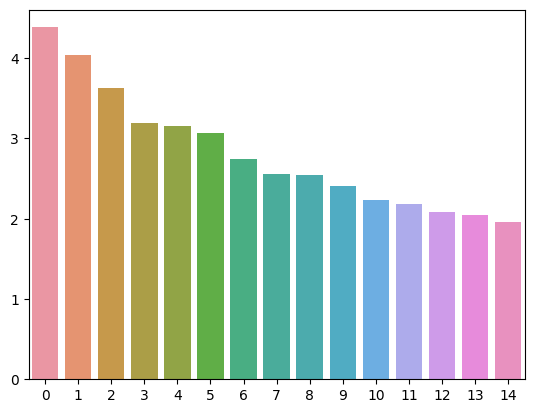

In [55]:
Sigma = svd.singular_values_
V_T = svd.components_.T
sns.barplot(x=list(range(len(Sigma))), y = Sigma)


In [56]:
vocab_df = pd.DataFrame.from_dict(index_to_word, orient='index', columns=['word']).sort_index()
print(vocab_df.head())

      word
0      1st
1     2023
2  24 hour
3       25
4       26


In [57]:
term_topic_matrix = pd.DataFrame(data=V_T, index=vocab_df.word, columns=[f'Latent_concept_{i}' for i in range(0, V_T.shape[1])])

<AxesSubplot: ylabel='word'>

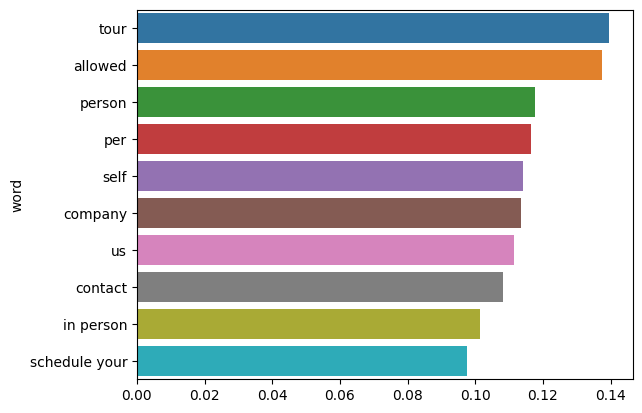

In [63]:
data = term_topic_matrix[f'Latent_concept_10']
data = data.sort_values(ascending=False)
top_10 = data[:10]
sns.barplot(x= top_10.values, y=top_10.index)

Below we look at correlation between phrases and price

In [ ]:

import copy 
import blurbs_corr 

DIR = '/home/bryce/Projects/Data_Science/Apt_Prices/csvs/march8/'

address_file =  DIR + 'pd_address_info.csv' 
apt_file = DIR + 'pd_apt_info.csv'

addr_df = pd.read_csv(address_file, sep=';')
apt_df = pd.read_csv(apt_file, sep=';')


min_doc_freq = .02
max_doc_freq = .20
ngram_range = (2, 3)

addr_df_copy = copy.copy(addr_df)

# 1. Compute the 'noncommon' words.

addr_df_copy['cleaned_blurbs'] = addr_df.blurb.map(blurbs_corr.BlurbFeatures._clean_text)
single_word_count_vectorizer = CountVectorizer(
    ngram_range=(1, 1), min_df=.02, max_df=.5)
_ = single_word_count_vectorizer.fit_transform(addr_df_copy.cleaned_blurbs)

word_to_index = single_word_count_vectorizer.vocabulary_
words = {w for w, i in word_to_index.items()}

tuple_count_vectorizer = CountVectorizer(ngram_range=(2, 3), min_df=min_doc_freq, max_df=max_doc_freq)
counts = tuple_count_vectorizer.fit_transform(addr_df_copy.cleaned_blurbs)
term_to_index = tuple_count_vectorizer.vocabulary_
index_to_term = {i : t for t, i in term_to_index.items()}
counts_df = pd.DataFrame(counts.toarray()).rename(columns=index_to_term)


# 2. Calculate the correlation between each term/phrase and the difference between that address's prices 
# and the median price of similar type of properties (e.g. apartments in the same zip code with the same number
# of beds).

addrs = addr_df_copy[['address']]
addrs_and_dummies = pd.concat((addrs, counts_df), axis=1)
assert(addrs_and_dummies.shape[0] == addrs.shape[0])
diffs_from_median = utility_methods.calculate_diff_from_median_price(apt_df = apt_df, addr_df = addr_df)

combined = diffs_from_median.merge(addrs_and_dummies, on='address')
corrs = combined.corr(numeric_only=True)[['avg_diff_from_median']].rename(columns={'avg_diff_from_median' : 'corr'})
corrs.sort_values(by='corr', ascending=False, inplace=True)
corrs.to_csv('/tmp/corrs.csv')